<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Hands on Lab: Complete the Machine Learning Prediction lab


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

<ipython-input-2-dfc2f4db4de1>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [4]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [8]:
Y = data['Class'].to_numpy()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [9]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Standardize the data and reassign to X
X = scaler.fit_transform(X)

# students get this 
#transform = preprocessing.StandardScaler()

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
# First split: Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)



we can see we only have 18 test samples.


In [11]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
# Create logistic regression object
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Define parameters dictionary (example - adjust based on your needs)
parameters ={
             'C':[0.01,0.1,1],
             #'C':[0.1, 1, 10, 100],
             'penalty': ['l1'],
             'solver': [ 'saga']}


# Create GridSearchCV object with cv=10
logreg_cv = GridSearchCV(
    estimator=logreg,
    param_grid=parameters,
    cv=10,
    scoring='accuracy',  # or other metric like 'f1', 'precision', 'recall'
    n_jobs=-1,  # use all available processors
    verbose=1  # to see progress
)

# Fit the GridSearchCV object to find the best parameters
logreg_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best parameters:", logreg_cv.best_params_)
print("\n","Best cross-validation score:", logreg_cv.best_score_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

 Best cross-validation score: 0.8607142857142855


In [13]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()


We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [14]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
accuracy : 0.8607142857142855


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [15]:
# Calculate accuracy on the test data
test_accuracy = logreg_cv.score(X_test, Y_test)

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8333


Lets look at the confusion matrix:


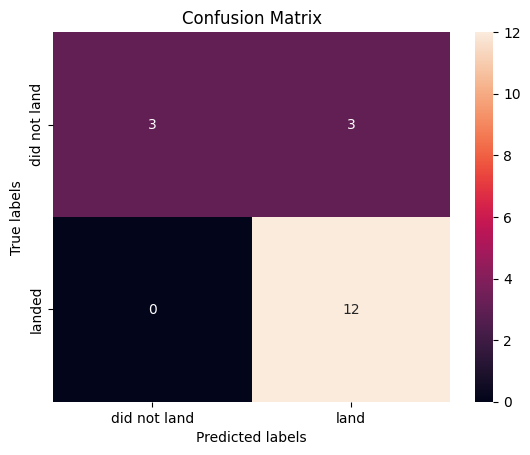

In [16]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [17]:
#parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              #'C': np.logspace(-3, 3, 5),
              #'gamma':np.logspace(-3, 3, 5)}
#svm = SVC()

# Create support vector machine object
svm = SVC(random_state=42)

# Define parameters dictionary for SVM
parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'degree': [2, 3, 4]  # Only used for polynomial kernel
}

# Create GridSearchCV object with cv=10
svm_cv = GridSearchCV(
    estimator=svm,
    param_grid=parameters,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV object to find the best parameters
svm_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best parameters:", svm_cv.best_params_)
print("Best cross-validation score:", svm_cv.best_score_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best cross-validation score: 0.8482142857142858


In [18]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [19]:
# Calculate accuracy on the test data
test_accuracy = svm_cv.score(X_test, Y_test)
print(f"SVM Test Accuracy: {test_accuracy:.4f}")

SVM Test Accuracy: 0.8333


We can plot the confusion matrix


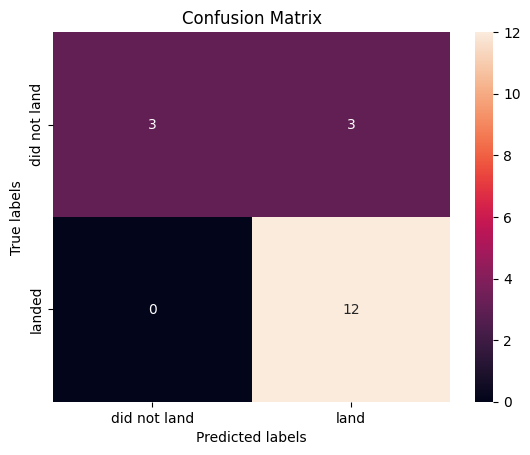

In [20]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [21]:
#parameters = {'criterion': ['gini', 'entropy'],
     #'splitter': ['best', 'random'],
     #'max_depth': [2*n for n in range(1,10)],
     #'max_features': ['auto', 'sqrt'],
     #'min_samples_leaf': [1, 2, 4],
     #'min_samples_split': [2, 5, 10]}

#tree = DecisionTreeClassifier()

# Create decision tree classifier object
tree = DecisionTreeClassifier(random_state=42)

# Define parameters dictionary for decision tree
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create GridSearchCV object with cv=10
tree_cv = GridSearchCV(
    estimator=tree,
    param_grid=parameters,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV object to find the best parameters
tree_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best parameters:", tree_cv.best_params_)
print("Best cross-validation score:", tree_cv.best_score_)

Fitting 10 folds for each of 896 candidates, totalling 8960 fits


/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2240 fits failed out of a total of 8960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2240 fits failed with the following error:
Traceback (most recent call last):
  File "/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_p

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation score: 0.8732142857142857


In [22]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}
accuracy : 0.8732142857142857


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [23]:
# Calculate accuracy on the test data
test_accuracy = tree_cv.score(X_test, Y_test)
print(f"Decision Tree Test Accuracy: {test_accuracy:.4f}")

Decision Tree Test Accuracy: 0.9444


We can plot the confusion matrix


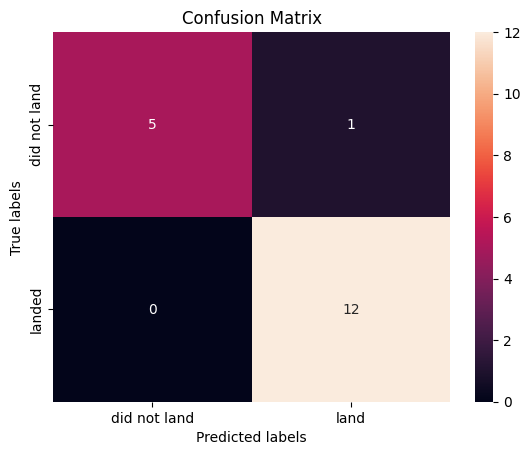

In [24]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [25]:
#parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1,2]}
#KNN = KNeighborsClassifier()

# Create k-nearest neighbors classifier object
knn = KNeighborsClassifier()

# Define parameters dictionary for KNN
parameters = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

# Create GridSearchCV object with cv=10
knn_cv = GridSearchCV(
    estimator=knn,
    param_grid=parameters,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV object to find the best parameters
knn_cv.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Best parameters: {'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Best cross-validation score: 0.8482142857142858


In [26]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [27]:
# Calculate accuracy on the test data
test_accuracy = knn_cv.score(X_test, Y_test)
print(f"KNN Test Accuracy: {test_accuracy:.4f}")

# You can also see the full results
results = knn_cv.cv_results_
print("\nTop 5 parameter combinations:")
for i in range(5):
    print(f"Rank {i+1}: {results['params'][i]} - Score: {results['mean_test_score'][i]:.4f}")

KNN Test Accuracy: 0.8333

Top 5 parameter combinations:
Rank 1: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'} - Score: 0.7804
Rank 2: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'} - Score: 0.7804
Rank 3: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'} - Score: 0.7500
Rank 4: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'} - Score: 0.7500
Rank 5: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'} - Score: 0.8054


We can plot the confusion matrix


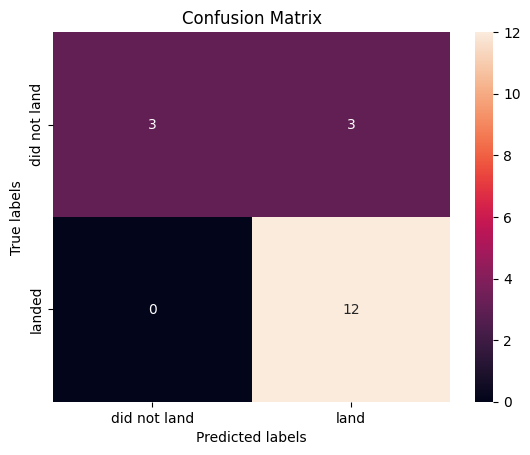

In [28]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


- The method that performed best is DecisionTree.
- Decision Tree Test Accuracy: 0.9444
- FP went from 3 to 1.


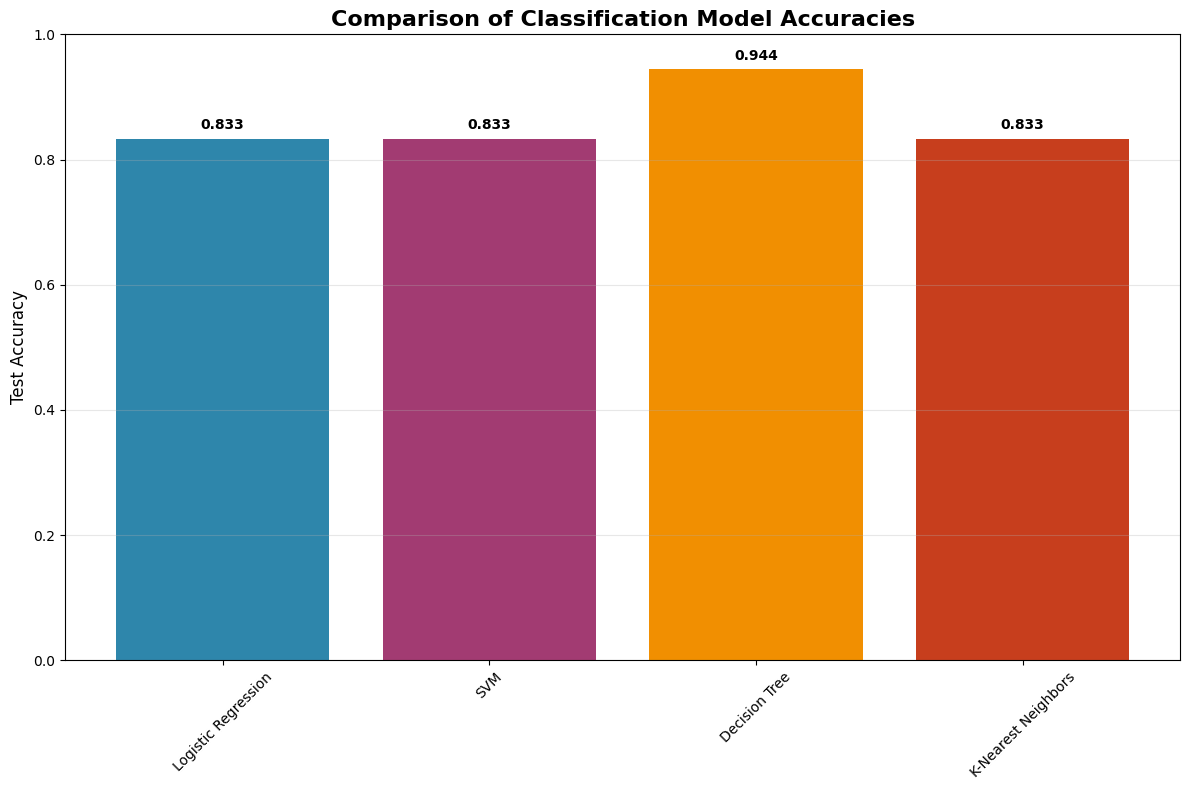

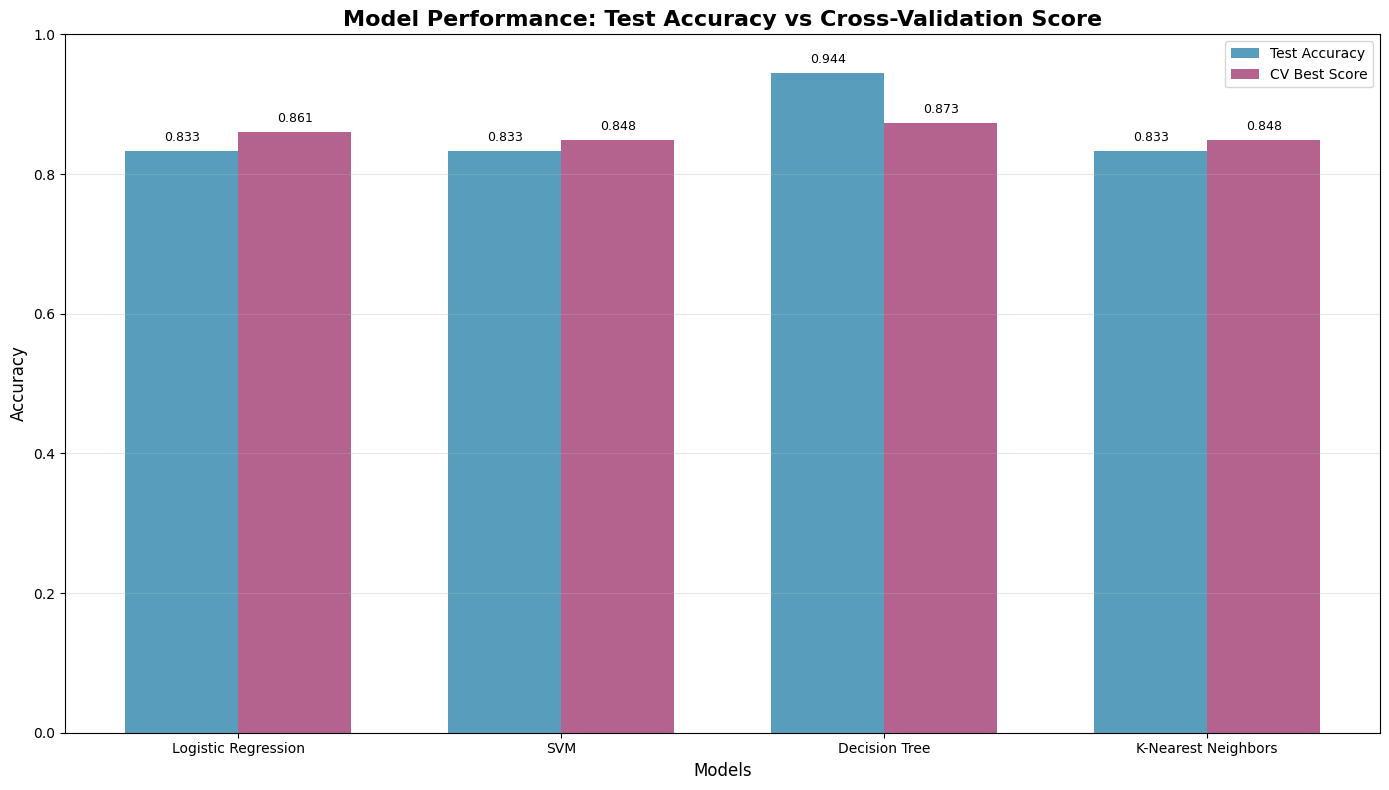


DETAILED MODEL PERFORMANCE SUMMARY

Logistic Regression:
  Test Accuracy: 0.8333
  CV Best Score: 0.8607
  Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

SVM:
  Test Accuracy: 0.8333
  CV Best Score: 0.8482
  Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}

Decision Tree:
  Test Accuracy: 0.9444
  CV Best Score: 0.8732
  Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}

K-Nearest Neighbors:
  Test Accuracy: 0.8333
  CV Best Score: 0.8482
  Best Parameters: {'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

🎯 BEST PERFORMING MODEL: Decision Tree (Accuracy: 0.9444)


In [30]:
# Calculate test accuracies for all models
models = ['Logistic Regression', 'SVM', 'Decision Tree', 'K-Nearest Neighbors']
model_vars = [logreg_cv, svm_cv, tree_cv, knn_cv]  # Reference to actual variables

test_accuracies = []
cv_scores = []

# Get test accuracy and CV scores for each model
for model_var in model_vars:
    test_accuracies.append(model_var.score(X_test, Y_test))
    cv_scores.append(model_var.best_score_)

# Create bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(models, test_accuracies, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])

# Customize the chart
plt.title('Comparison of Classification Model Accuracies', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of each bar
for bar, accuracy in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a comprehensive comparison chart
plt.figure(figsize=(14, 8))

# Set width of bars
bar_width = 0.35
x_pos = np.arange(len(models))

# Create bars
bars1 = plt.bar(x_pos - bar_width/2, test_accuracies, bar_width, 
                label='Test Accuracy', color='#2E86AB', alpha=0.8)
bars2 = plt.bar(x_pos + bar_width/2, cv_scores, bar_width, 
                label='CV Best Score', color='#A23B72', alpha=0.8)

# Customize the comprehensive chart
plt.title('Model Performance: Test Accuracy vs Cross-Validation Score', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(x_pos, models)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*60)
print("DETAILED MODEL PERFORMANCE SUMMARY")
print("="*60)
for i, (model, model_var) in enumerate(zip(models, model_vars)):
    print(f"\n{model}:")
    print(f"  Test Accuracy: {test_accuracies[i]:.4f}")
    print(f"  CV Best Score: {cv_scores[i]:.4f}")
    print(f"  Best Parameters: {model_var.best_params_}")

# Find and highlight the best performing model
best_model_idx = np.argmax(test_accuracies)
print(f"\n🎯 BEST PERFORMING MODEL: {models[best_model_idx]} "
      f"(Accuracy: {test_accuracies[best_model_idx]:.4f})")

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
